## Preparation

In [17]:
import glob
import json
import os
import random
from datetime import datetime
from importlib import import_module

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('../')
from loss import create_criterion

In [33]:
"""
All you need is to change this line only.
"""

model_path = "../model/2023.04.26-11:32:03"

In [34]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [35]:
with open(os.path.join(model_path, "model_config.json")) as f:
    config = json.load(f)

In [36]:
seed_everything(config["seed"])

In [37]:
all_img_list = glob.glob(os.path.join('..', config["data_save_dir"], "train/*/*"))

df = pd.DataFrame(columns=["img_path", "label"])
df["img_path"] = all_img_list
df["label"] = df["img_path"].apply(lambda x: str(x).split("/")[-2])

train_ds, val_ds, _, _ = train_test_split(
    df,
    df["label"],
    test_size=config["params"]["val_ratio"],
    stratify=df["label"],
    random_state=42,
)

le = preprocessing.LabelEncoder()
train_ds["label"] = le.fit_transform(train_ds["label"])
val_ds["label"] = le.transform(val_ds["label"])

dataset_module = getattr(import_module("data"), config["dataset"])

test_transform_module = getattr(import_module("data"), config["augment"]["test"])
test_transform = test_transform_module(resize=config["augment"]["resize"])
val_dataset = dataset_module(val_ds["img_path"].values, val_ds["label"].values, test_transform)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["params"]["batch_size"],
    shuffle=False,
    num_workers=4,
)

/tmp/ipykernel_14642/468924297.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ds["label"] = le.fit_transform(train_ds["label"])
/tmp/ipykernel_14642/468924297.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_ds["label"] = le.transform(val_ds["label"])


In [38]:
model_module = getattr(import_module("model"), config["model"])
model = model_module()
ckpt = torch.load(os.path.join(model_path, "best.pth"))
model.load_state_dict(ckpt)
model.to("cuda")

criterion = create_criterion(config["criterion"]["type"], **config["criterion"]["args"])

In [39]:
model.eval()
val_loss = []
preds, true_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(iter(val_loader)):
        imgs = imgs.float().to("cuda")
        labels = labels.to("cuda")

        pred = model(imgs)

        loss = criterion(pred, labels)

        preds += pred.argmax(1).detach().cpu().numpy().tolist()
        true_labels += labels.detach().cpu().numpy().tolist()

        val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    _val_score = f1_score(true_labels, preds, average="weighted")

100%|██████████| 33/33 [00:16<00:00,  1.97it/s]


In [40]:
print(_val_loss, _val_score)

try:
    assert _val_loss == config["best_loss"]
    assert _val_score == config["best_score"]
    print("reproduction success")
except AssertionError:
    print("reproduction failed!")

0.6494876191471562 0.8582648620629509
reproduction success


-----------------------------------

## Confusion matrix

In [16]:
# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
from sklearn.metrics import confusion_matrix
import seaborn as sn

<AxesSubplot:>

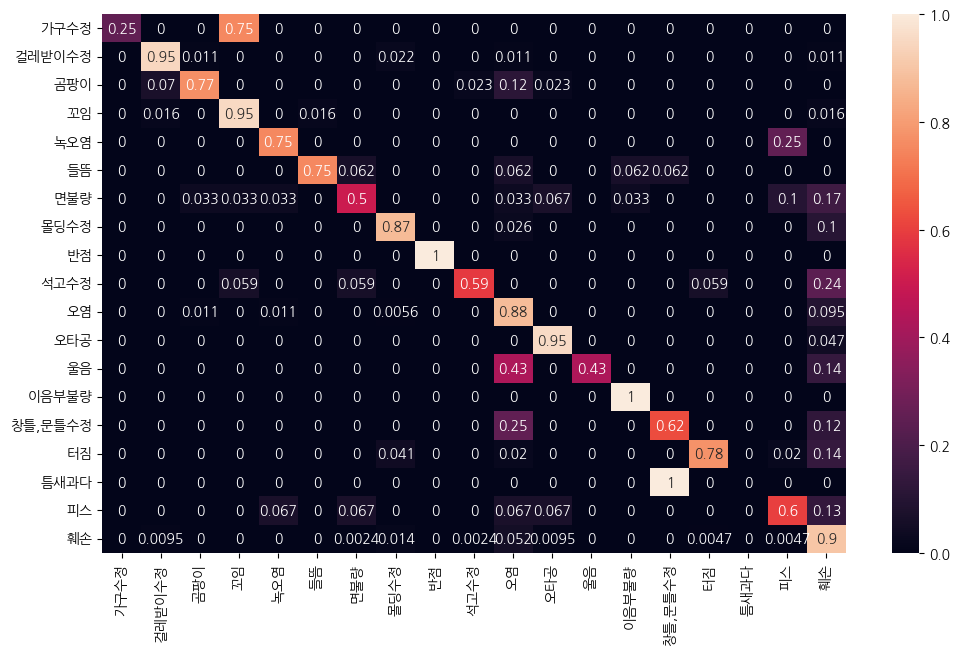

In [23]:
cf_matrix = confusion_matrix(true_labels, preds)
classes = le.inverse_transform(list(range(19)))

plt.rcParams['font.family'] = 'NanumGothic'
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

-------------------------

## GradCAM

### Preparation

In [405]:
import cv2

In [406]:
model_module = getattr(import_module("model"), config["model"])
model = model_module()
ckpt = torch.load(os.path.join(model_path, "best.pth"))
model.load_state_dict(ckpt)
model.to("cuda")
_ = model.eval()

In [407]:
def denorm_image(img, size):
    c1 = torch.zeros(1, *size) + 0.229
    c2 = torch.zeros(1, *size) + 0.224
    c3 = torch.zeros(1, *size) + 0.225
    std_cn = torch.cat((c1, c2, c3), dim=0)

    c1 = torch.zeros(1, *size) + 0.485
    c2 = torch.zeros(1, *size) + 0.456
    c3 = torch.zeros(1, *size) + 0.406
    std_mean = torch.cat((c1, c2, c3), dim=0)
    
    return img.cpu() * std_cn + std_mean

In [408]:
last_conv_module = None
last_conv_name = None
for name, module in reversed(list(model.named_modules())):
    if isinstance(module, torch.nn.modules.conv.Conv2d):
        last_conv_module = module
        last_conv_name = name
        break

In [409]:
grads = []
activations = []
def back_hook(grad):
    grads.append(grad)
    
def hook(module, input, output):
    if module == last_conv_module:
        output.register_hook(back_hook)
        activations.append(output)
    
for module in model.modules():
    module.register_forward_hook(hook)

### GradCAM 출력

predict : 18 ['훼손'] , label : 18 ['훼손']


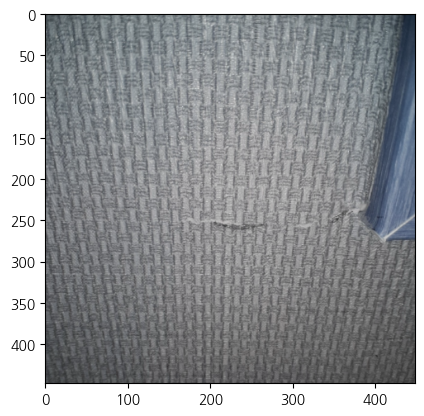

In [477]:
img_idx = 1000
img_to_show = denorm_image(val_dataset[img_idx][0], config["augment"]["resize"])
output = model(val_dataset[img_idx][0].unsqueeze(dim=0).to("cuda"))

print("predict :", output.argmax(dim=-1).item(),le.inverse_transform(output.argmax(dim=-1).cpu().detach()),
      ", label :", val_dataset[img_idx][1],le.inverse_transform([val_dataset[img_idx][1]]))
plt.imshow(img_to_show.permute(1,2,0))

In [478]:
pred = output.argmax(dim=-1)
output[:, pred.item()].backward()

gradients = grads[-1].cpu()
activation = activations[-1].cpu().detach()

gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
alpha = gap_layer(gradients[0].squeeze())
A = activation.squeeze()

relu_layer = torch.nn.ReLU()

weighted_sum = torch.sum(alpha*A, dim=0)
grad_CAM = relu_layer(weighted_sum)

grad_CAM = grad_CAM.unsqueeze(0)
grad_CAM = grad_CAM.unsqueeze(0)

upscale_layer = torch.nn.Upsample(scale_factor=img_to_show.shape[-1]/grad_CAM.shape[-1], mode='bilinear')

grad_CAM = upscale_layer(grad_CAM)
grad_CAM = grad_CAM/torch.max(grad_CAM)


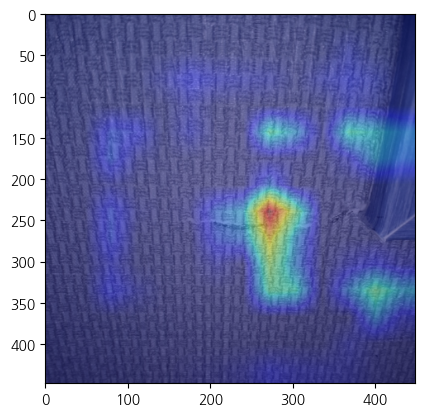

In [479]:
# 붉은색이 집중하는 부분
plt.imshow(img_to_show.permute(1,2,0))
plt.imshow(grad_CAM[0][0], alpha=0.4, cmap='jet')